<a href="https://colab.research.google.com/github/KeremAydin98/using-pretrained-network/blob/main/pretrained_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications.resnet import ResNet50, preprocess_input
from tensorflow.keras.applications.xception import Xception, preprocess_input
from glob import glob
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
!wget -nc https://lazyprogrammer.me/course_files/fruits-360.zip    
!unzip -nq fruits-360.zip

--2022-01-02 10:45:11--  https://lazyprogrammer.me/course_files/fruits-360.zip
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 190820824 (182M) [application/zip]
Saving to: ‘fruits-360.zip’

fruits-360.zip      100%[===================>] 181.98M  29.5MB/s    in 7.1s    

2022-01-02 10:45:18 (25.7 MB/s) - ‘fruits-360.zip’ saved [190820824/190820824]



In [14]:
class Pretrained_network():

  def __init__(self,image_size=[100,100],batch_size=32,epochs=4):

    self.image_size = image_size
    self.batch_size = batch_size
    self.epochs = epochs

  def generating_data(self):

    self.train_path = 'fruits-360/Training'
    self.valid_path = 'fruits-360/Validation'

    self.image_files = glob(self.train_path + '/*/*.jp*g')
    self.valid_image_files = glob(self.valid_path + '/*/*.jp*g')

    self.folders = glob(self.train_path + '/*')

    self.train_gen = ImageDataGenerator(
      rotation_range=20,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.1,
      zoom_range=0.2,
      horizontal_flip=True,
      vertical_flip=True,
      preprocessing_function=preprocess_input
    )

    self.validation_gen = ImageDataGenerator(
      preprocessing_function=preprocess_input 
    )

    self.train_generator = self.train_gen.flow_from_directory(self.train_path,
                                                target_size=self.image_size,
                                                shuffle=True,
                                                batch_size=self.batch_size,
                                                class_mode='categorical')

    self.validation_generator = self.validation_gen.flow_from_directory(self.valid_path,
                                                     target_size=self.image_size,
                                                     shuffle=False,
                                                     batch_size=self.batch_size,
                                                     class_mode='categorical')
    self.test_datagen = ImageDataGenerator(rescale=1/255)

    return self.train_generator, self.validation_generator, self.test_datagen

  def convolution_model(self,model):

    convolution_base = model(include_top = False, weights = 'imagenet',input_shape= self.image_size + [3])

    #dont train existing weights 
    for layer in convolution_base.layers:
      layer.trainable = False

    return convolution_base

  def neural_networks(self, convolution_base):

    model = Sequential()
    model.add(convolution_base)
    model.add(Flatten())
    model.add(Dense(1000,activation='relu',input_dim= 100 * 100 * 3))
    model.add(Dense(len(self.folders),activation='softmax'))

    model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['acc'])

    return model

  def train_model(self,model,train_generator, validation_generator, test_datagen):

    history = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=self.epochs,
                    steps_per_epoch=train_generator.samples//self.batch_size,
                    validation_steps=validation_generator.samples//self.batch_size)
    
    return history

  def get_confusion_matrix(self, model):
    print("***Generating confusion matrix***")
    predictions = []
    targets = []
    i = 0
    n_images=0
    for x, y in self.test_datagen.flow_from_directory(self.valid_path,
                                       target_size=self.image_size,
                                       shuffle=False,
                                       batch_size=self.batch_size*2):
        i += 1
        n_images += len(y)
        if i % 50 == 0:
            print(f'{n_images} images processed')
        p = model.predict(x)
        p = np.argmax(p, axis=1)
        y = np.argmax(y, axis=1)
        predictions = np.concatenate((predictions, p))
        targets = np.concatenate((targets, y))
        if len(targets) >= len(self.valid_image_files):
            break

    self.cm = confusion_matrix(targets, predictions)
    plt.figure(figsize=(30,30))
    sns.heatmap(self.cm, annot=False,cmap='Blues')
    plt.show()
    
  def accuracy_and_loss(self, history):

    fig, ax = plt.subplots(1, 2)
    ax[0].plot(history.history['loss'],label='loss')
    ax[0].plot(history.history['val_loss'],label='val_loss')
    ax[0].legend()
    ax[0].set_title('Loss')
    ax[1].plot(history.history['acc'],label='acc')
    ax[1].plot(history.history['val_acc'],label='val_acc')
    ax[1].legend()
    ax[1].set_title('Accuracy')

In [4]:
pre = Pretrained_network()

train_generator, validation_generator, test_datagen = pre.generating_data()

VGG16_convolution_model = pre.convolution_model(VGG16)
VGG16_model = pre.neural_networks(VGG16_convolution_model)

resnet_convolution_model = pre.convolution_model(ResNet50)
ResNet50_model = pre.neural_networks(resnet_convolution_model)

Xception_convolution_model = pre.convolution_model(Xception)
Xception_model = pre.neural_networks(Xception_convolution_model)

Found 28736 images belonging to 60 classes.
Found 9673 images belonging to 60 classes.
83697664/83683744 [==============================] - 1s 0us/step


**VGG16**

In [5]:
history_vgg = pre.train_model(VGG16_model,train_generator, validation_generator, test_datagen)

Epoch 1/4
898/898 [==============================] - 150s 156ms/step - loss: 0.4897 - acc: 0.8652 - val_loss: 0.1934 - val_acc: 0.9399
Epoch 2/4
898/898 [==============================] - 138s 154ms/step - loss: 0.1145 - acc: 0.9622 - val_loss: 0.2287 - val_acc: 0.9239
Epoch 3/4
898/898 [==============================] - 138s 153ms/step - loss: 0.0957 - acc: 0.9678 - val_loss: 0.2870 - val_acc: 0.9408
Epoch 4/4
898/898 [==============================] - 138s 154ms/step - loss: 0.0940 - acc: 0.9681 - val_loss: 0.1169 - val_acc: 0.9611


***Generating confusion matrix***
Found 9673 images belonging to 60 classes.
3200 images processed
6400 images processed
9600 images processed


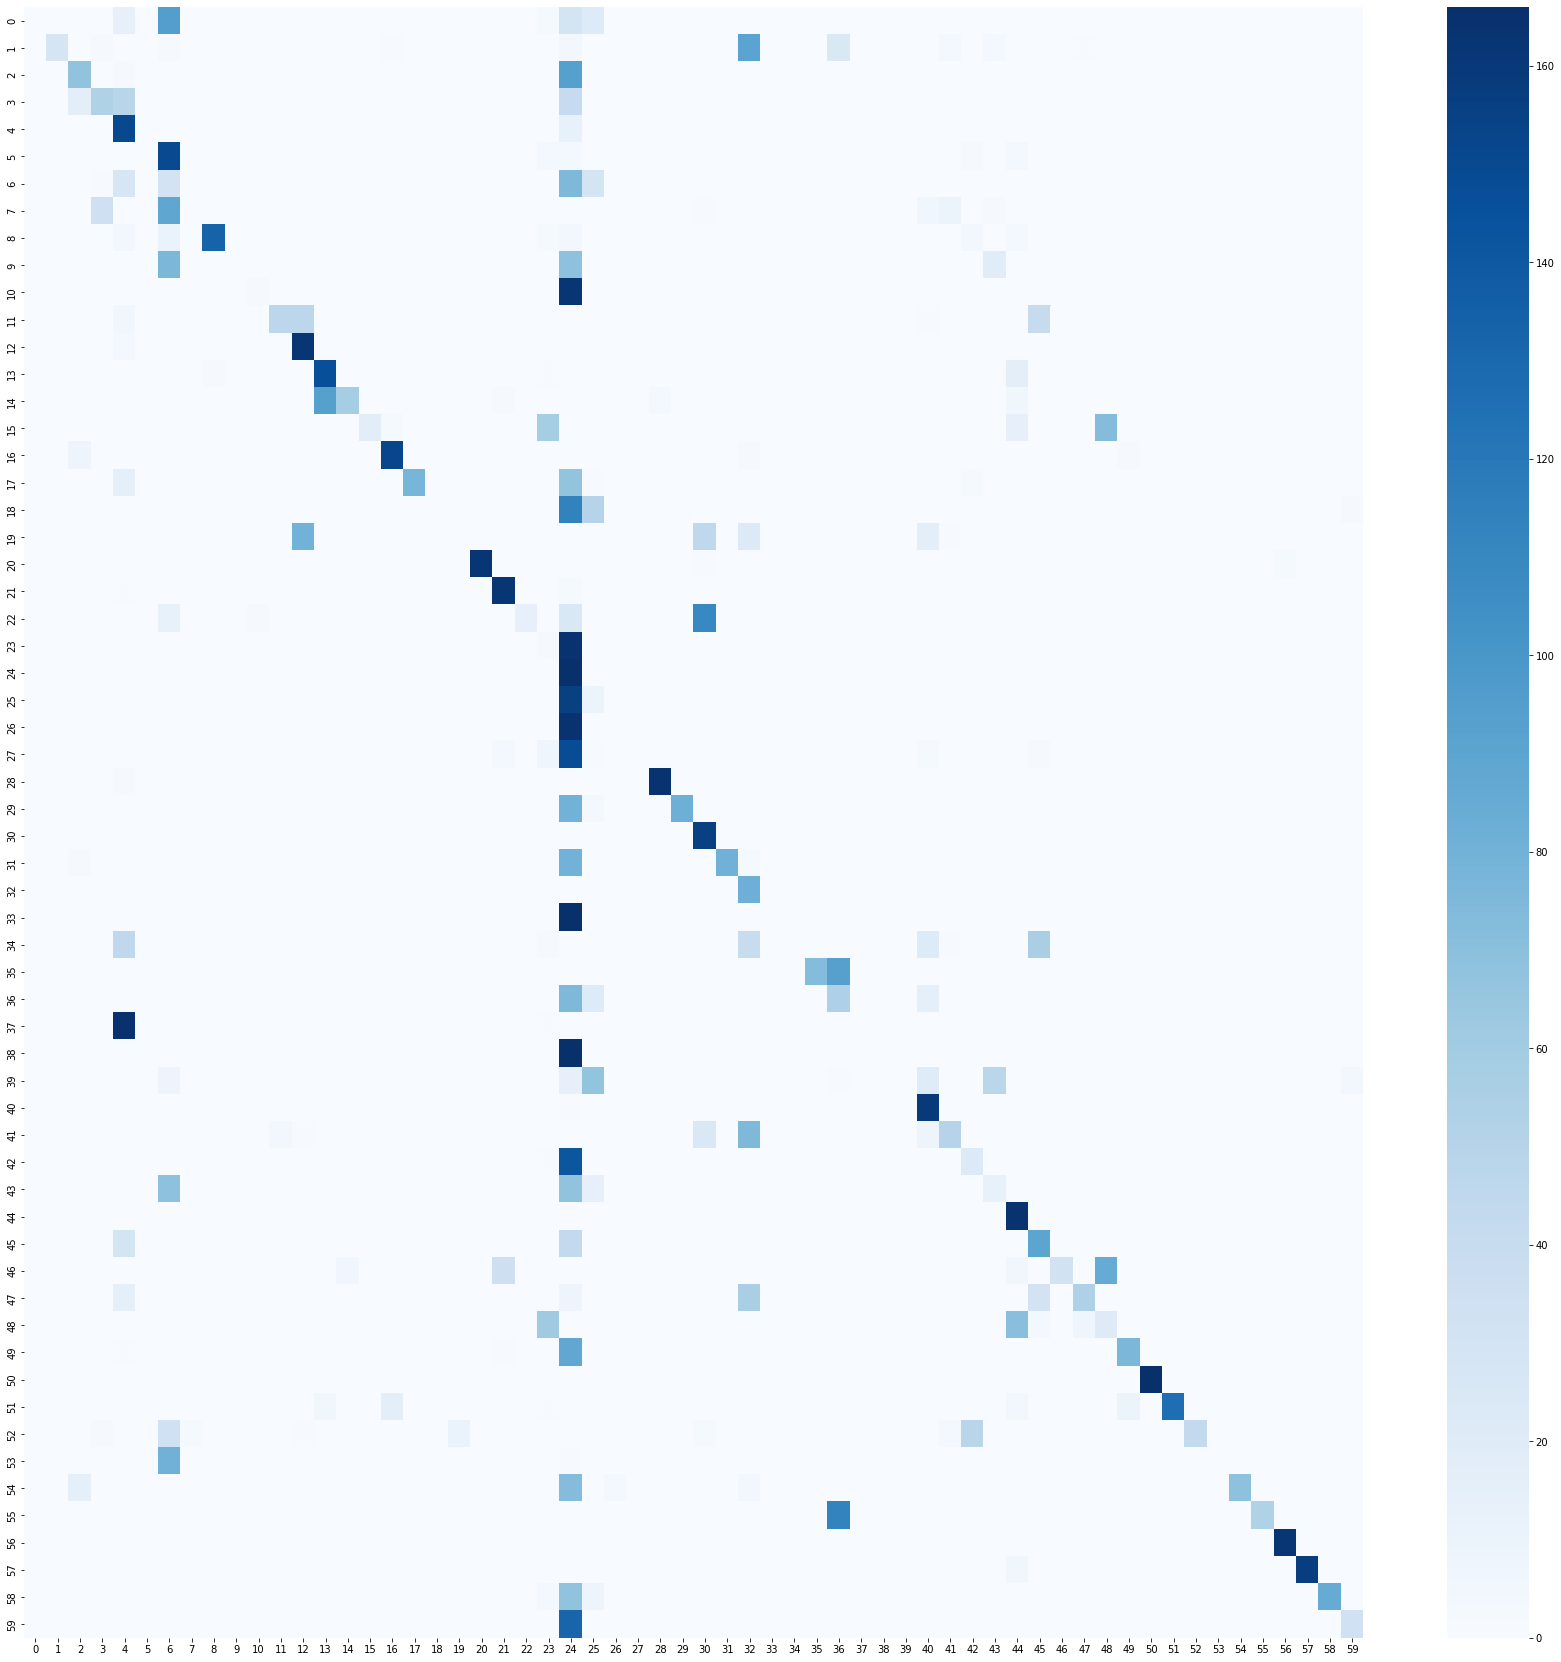

In [6]:
pre.get_confusion_matrix(VGG16_model)

<Figure size 360x360 with 0 Axes>

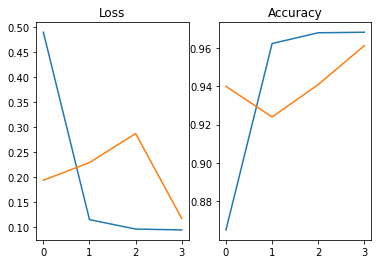

In [7]:
pre.accuracy_and_loss(history_vgg)

**ResNet50**

In [8]:
history_res = pre.train_model(ResNet50_model,train_generator, validation_generator, test_datagen)

Epoch 1/4
898/898 [==============================] - 167s 177ms/step - loss: 3.0072 - acc: 0.2775 - val_loss: 1.9177 - val_acc: 0.4422
Epoch 2/4
898/898 [==============================] - 147s 163ms/step - loss: 1.6200 - acc: 0.4965 - val_loss: 1.3385 - val_acc: 0.5608
Epoch 3/4
898/898 [==============================] - 147s 164ms/step - loss: 1.2591 - acc: 0.5921 - val_loss: 1.3306 - val_acc: 0.5866
Epoch 4/4
898/898 [==============================] - 148s 165ms/step - loss: 1.0879 - acc: 0.6426 - val_loss: 1.0383 - val_acc: 0.6518


***Generating confusion matrix***
Found 9673 images belonging to 60 classes.
3200 images processed
6400 images processed
9600 images processed


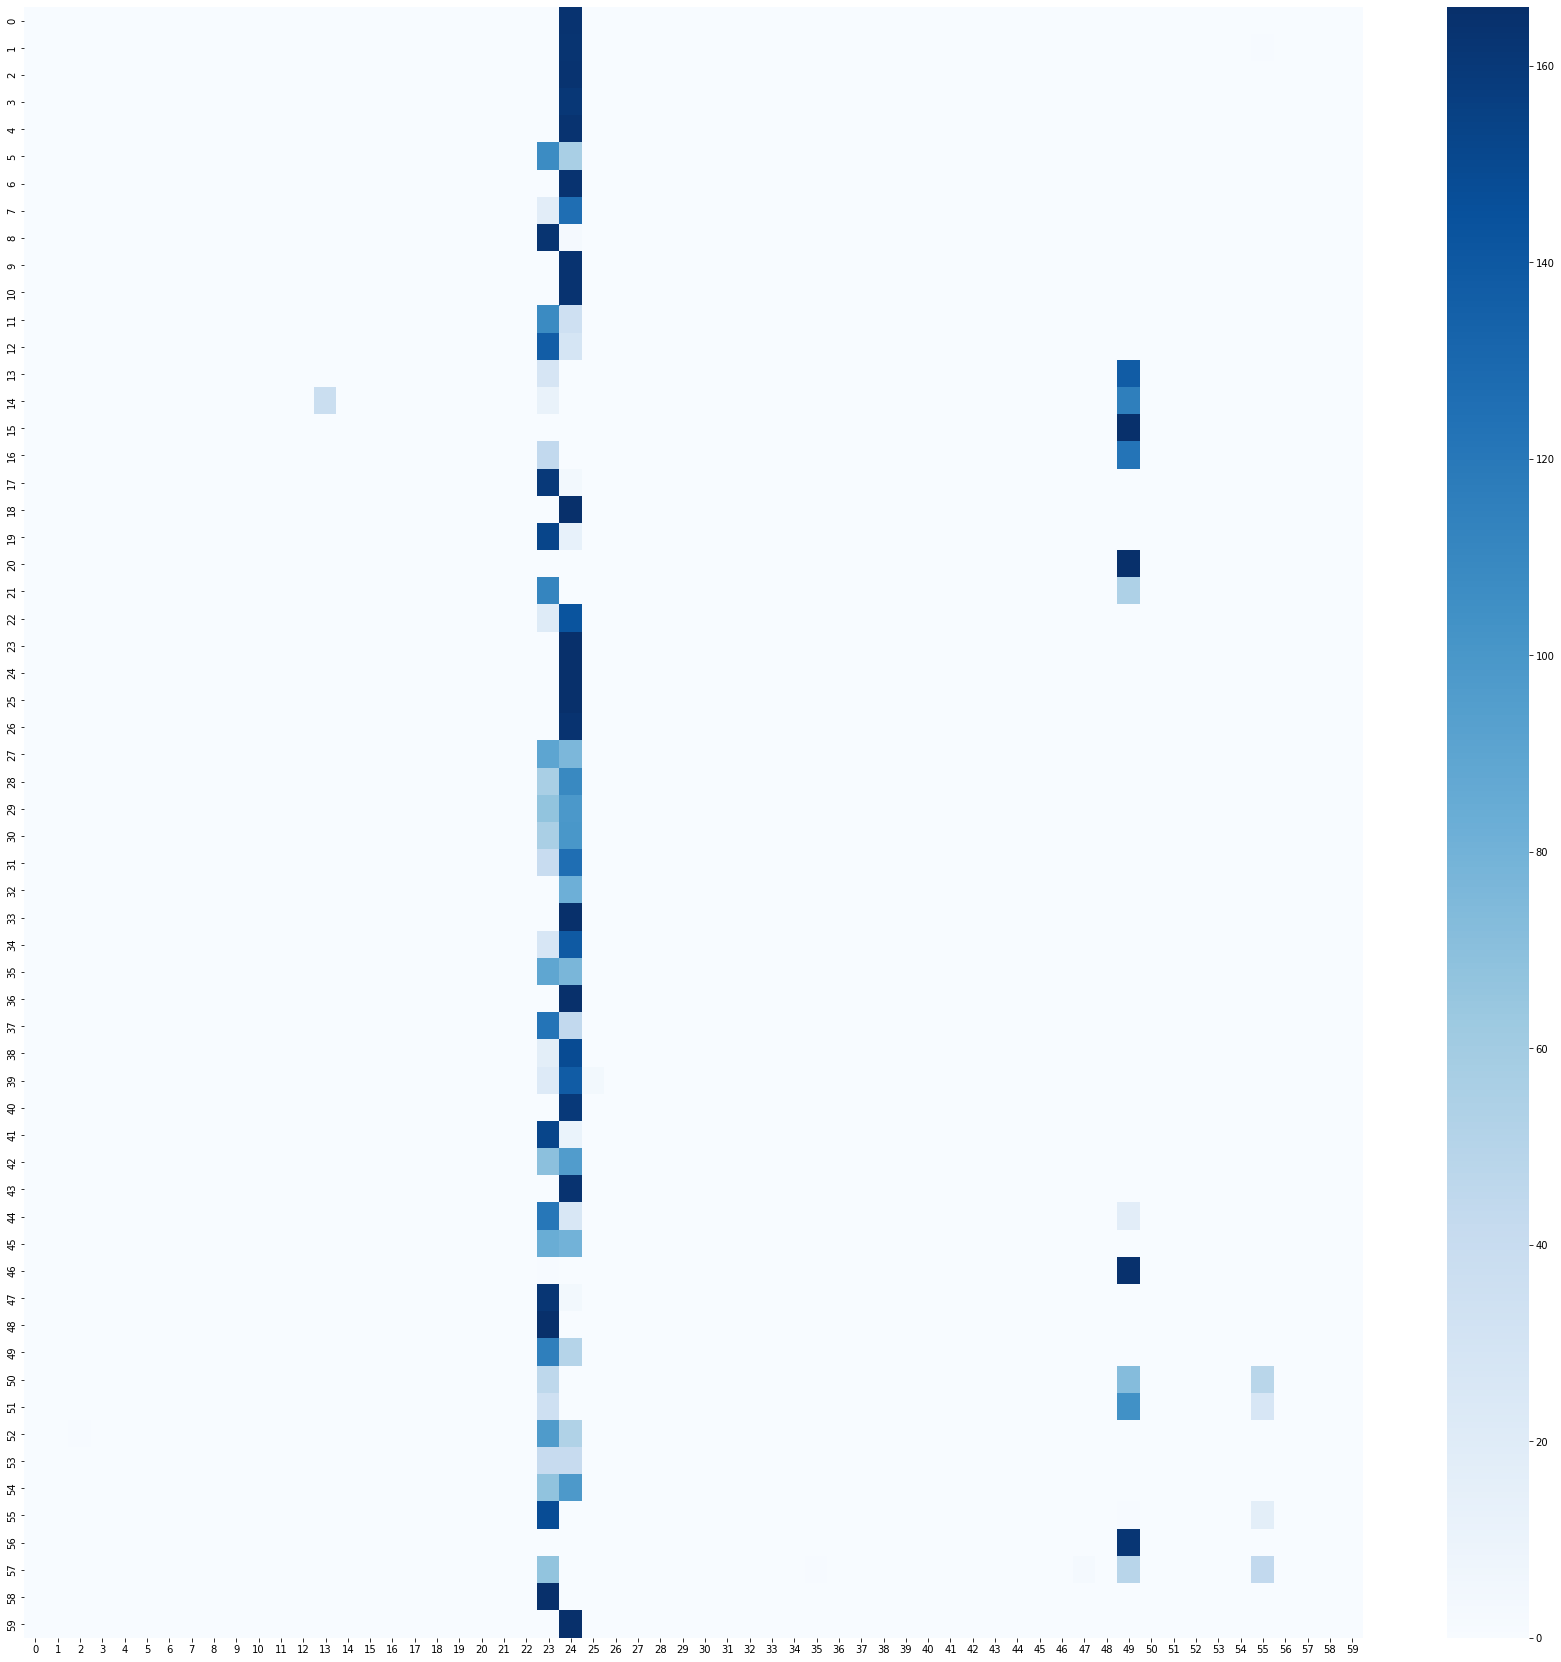

In [9]:
pre.get_confusion_matrix(ResNet50_model)

<Figure size 360x360 with 0 Axes>

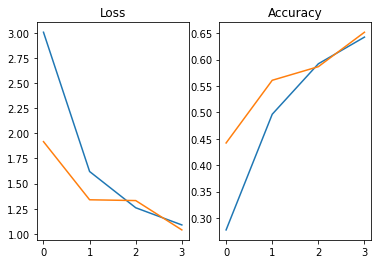

In [10]:
pre.accuracy_and_loss(history_res)

**Xception**

In [11]:
history_xcep = pre.train_model(Xception_model,train_generator, validation_generator, test_datagen)

Epoch 1/4
898/898 [==============================] - 144s 156ms/step - loss: 0.7239 - acc: 0.8473 - val_loss: 0.4668 - val_acc: 0.8689
Epoch 2/4
898/898 [==============================] - 135s 151ms/step - loss: 0.2505 - acc: 0.9248 - val_loss: 0.3467 - val_acc: 0.9079
Epoch 3/4
898/898 [==============================] - 137s 152ms/step - loss: 0.2198 - acc: 0.9384 - val_loss: 0.4078 - val_acc: 0.8979
Epoch 4/4
898/898 [==============================] - 137s 152ms/step - loss: 0.2145 - acc: 0.9415 - val_loss: 0.4569 - val_acc: 0.9005


***Generating confusion matrix***
Found 9673 images belonging to 60 classes.
3200 images processed
6400 images processed
9600 images processed


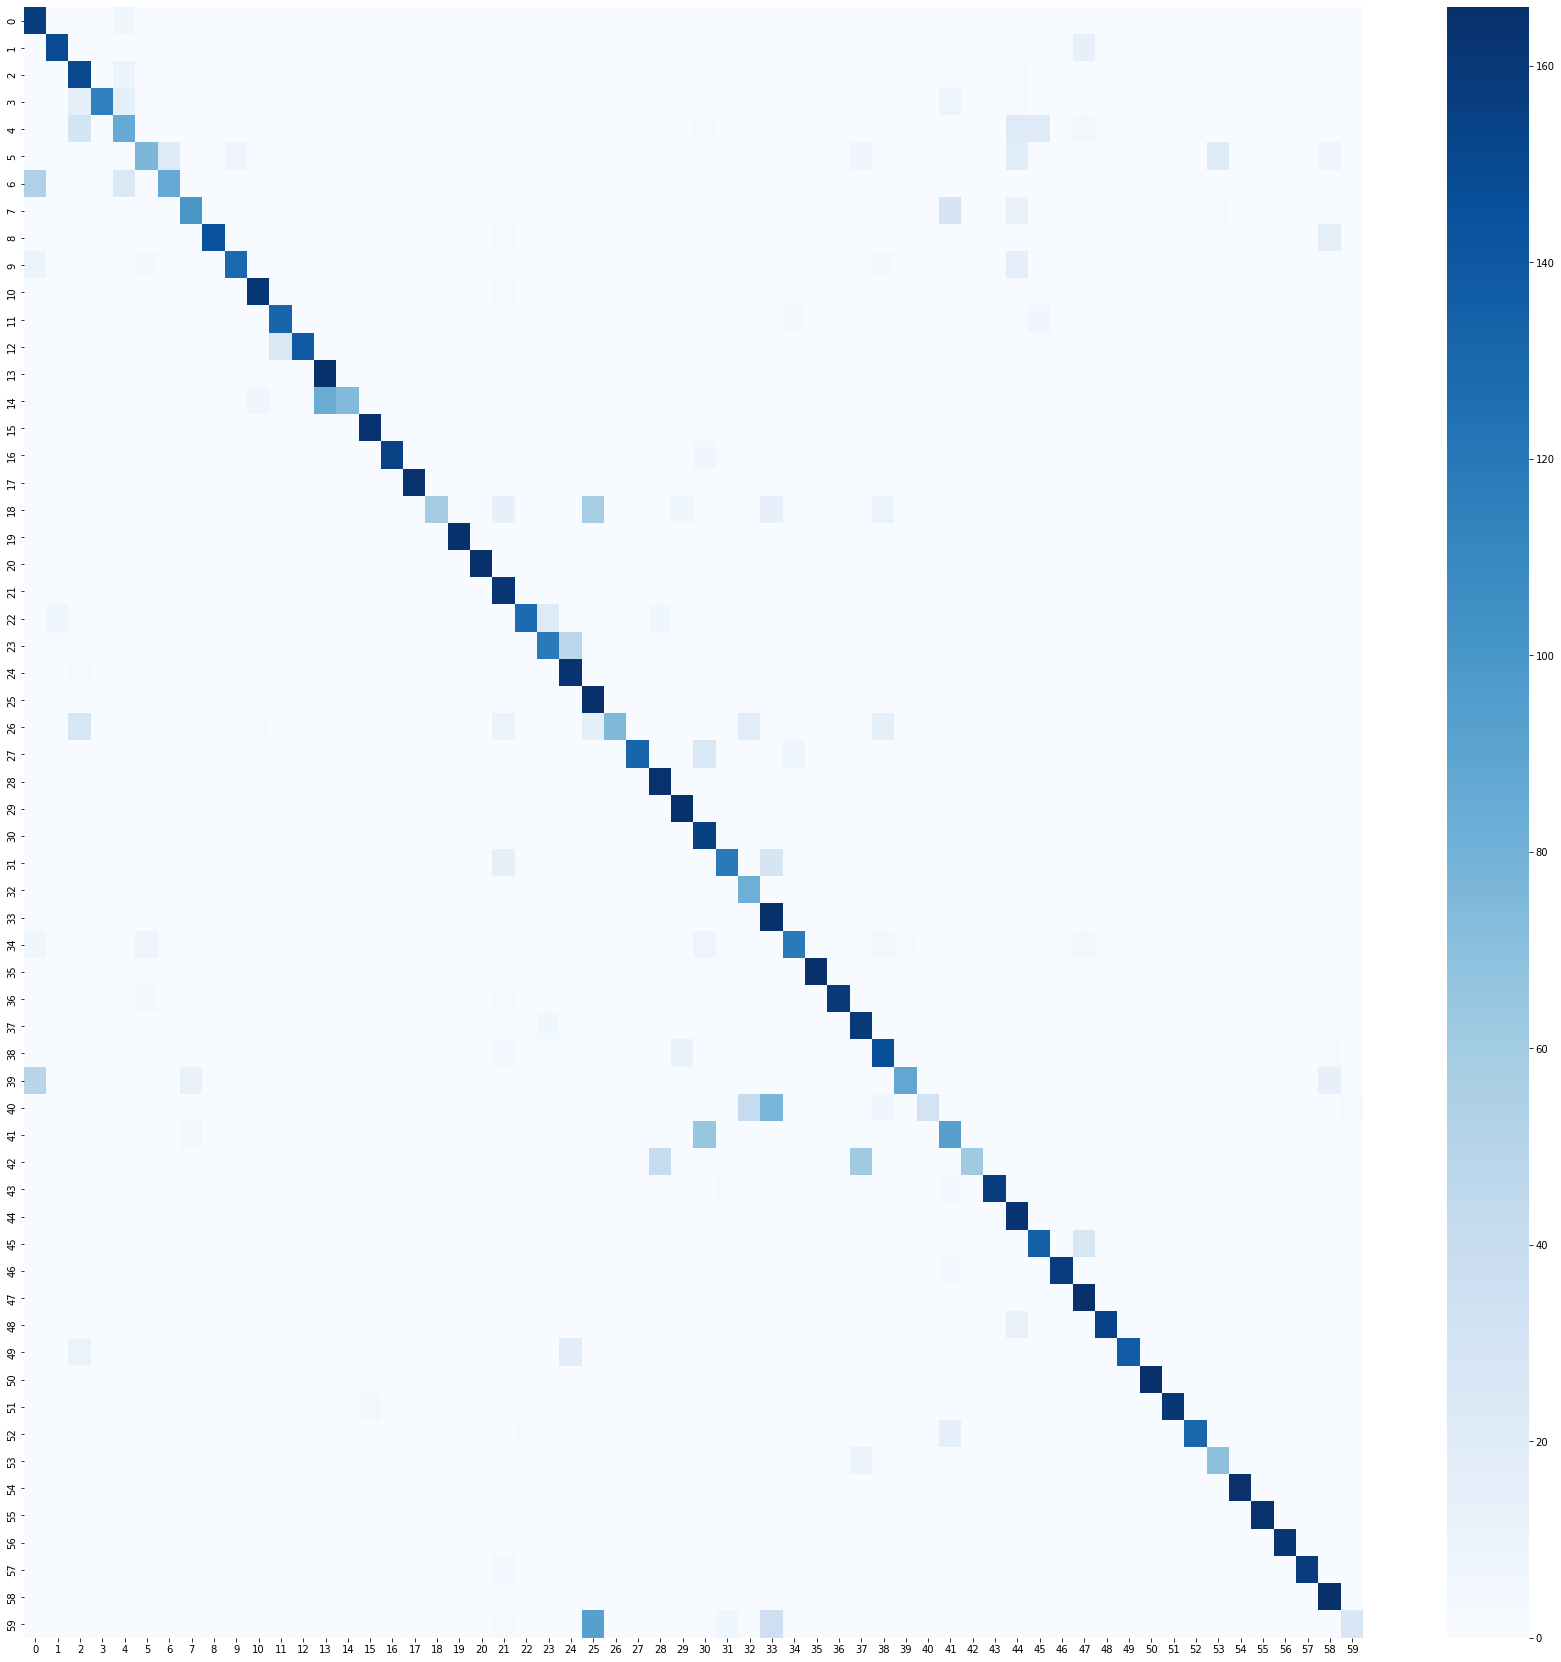

In [12]:
pre.get_confusion_matrix(Xception_model)

<Figure size 360x360 with 0 Axes>

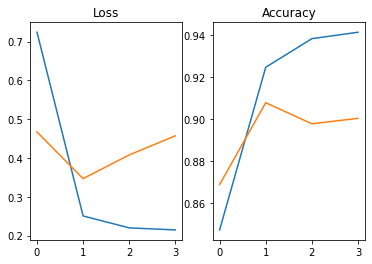

In [13]:
pre.accuracy_and_loss(history_xcep)